# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/path/to/Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
#for i in range(5):                                         # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Import necessary packages

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from collections import deque

# import agent
from ddpg_agent import Agent

# Record training time
import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Europe/Brussels"))
    return pst_now.strftime(format)

## Initiate evironment and agents

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# Setup two independent agents with shared experience memory
agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)

## Training

In [9]:
start_time = get_time('%Y-%m-%d--%H:%M:%S')

n_episodes = 2000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []
WITH_NOISE = True
solved = False
best_score = 0.0

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,state_size * num_agents))
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, WITH_NOISE)         # agent 0 chooses an action
        action_1 = agent_1.act(states, WITH_NOISE)         # agent 1 chooses an action
        actions = np.concatenate((action_0, action_1), axis=0) 
        actions = np.reshape(actions, (1, action_size * num_agents))
        env_info = env.step(actions)[brain_name]           # send actions of both agents to the environment
        next_states = env_info.vector_observations         # get next states
        next_states = np.reshape(next_states, (1, state_size * num_agents))     
        rewards = env_info.rewards                         # get the reward
        done = env_info.local_done                         # check if episode finished

        agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 0 learns
        agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 1 learns
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                   # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
    print('\rEpisode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
        i_episode, np.max(scores), np.mean(scores_window)), end="")
                
    if i_episode % 100 == 0:
        print('\rEpisode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
            i_episode, np.max(scores), np.mean(scores_window)))
        if solved and np.mean(scores_window)>best_score:    # only save model weight with best result
            print('\n*** Better score reached in {:d} episodes!\tAverage Score: {:.3f}'.format(
                i_episode, np.mean(scores_window)))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0_best.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0_best.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1_best.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1_best.pth')

    if np.mean(scores_window)>=0.5 and not solved:
        print('\n*** Environment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode, np.mean(scores_window)))
        solved = True
        best_score = np.mean(scores_window)
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0_{}.pth'.format(get_time('%Y-%m-%d--%H:%M:%S')))
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0_{}.pth'.format(get_time('%Y-%m-%d--%H:%M:%S')))
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1_{}.pth'.format(get_time('%Y-%m-%d--%H:%M:%S')))
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1_{}.pth'.format(get_time('%Y-%m-%d--%H:%M:%S')))
print ("\n*** TRAIN STARTED AT {} ".format(start_time))
print ("\n*** TRAIN FINISHED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

Episode 100	Max Reward: 0.000	Average Reward: 0.008
Episode 200	Max Reward: 0.100	Average Reward: 0.035
Episode 300	Max Reward: 0.200	Average Reward: 0.087
Episode 400	Max Reward: 0.000	Average Reward: 0.130
Episode 500	Max Reward: 0.300	Average Reward: 0.166
Episode 600	Max Reward: 0.200	Average Reward: 0.302
Episode 642	Max Reward: 2.600	Average Reward: 0.520
*** Environment solved in 642 episodes!	Average Score: 0.520
Episode 700	Max Reward: 0.600	Average Reward: 0.676

*** Better score reached in 700 episodes!	Average Score: 0.676
Episode 800	Max Reward: 0.100	Average Reward: 0.513
Episode 900	Max Reward: 0.500	Average Reward: 0.518
Episode 1000	Max Reward: 0.790	Average Reward: 0.484
Episode 1100	Max Reward: 0.300	Average Reward: 0.484
Episode 1200	Max Reward: 0.100	Average Reward: 0.333
Episode 1300	Max Reward: 0.500	Average Reward: 0.296
Episode 1400	Max Reward: 0.300	Average Reward: 0.402
Episode 1500	Max Reward: 0.500	Average Reward: 0.363
Episode 1600	Max Reward: 0.100	Averag

## Plot the training result

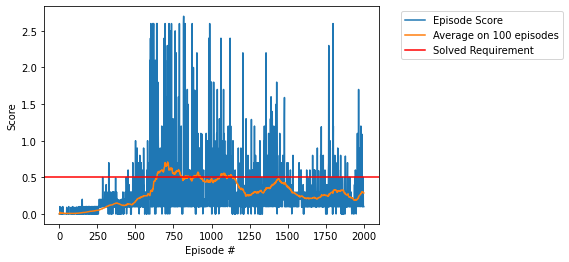

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores_all) + 1), scores_all, label="Episode Score")
plt.plot(np.arange(1, len(rolling_average) + 1), 
    rolling_average, label="Average on 100 episodes") 
# This line indicates the score at which the environment is considered solved
plt.axhline(y=0.5, color="r",  label="Solved Requirement") 

plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel("Score")
plt.xlabel("Episode # ")
plt.show()